<a href="https://colab.research.google.com/github/koreahong/credit_analysis/blob/main/catboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install category_encoders

In [ ]:
!pip install catboost

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook
import math
import warnings
warnings.filterwarnings("ignore")
#폰트설정
plt.rc('font', family='NanumBarunGothic') 

from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from category_encoders.ordinal import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold

from sklearn.cluster import KMeans
from catboost import CatBoostClassifier, Pool

In [476]:
train = pd.read_csv("/content/drive/MyDrive/머신러닝_실전예제/Dacon_신용카드연체판별/data/open/train.csv", index_col=0)

In [477]:
test = pd.read_csv("/content/drive/MyDrive/머신러닝_실전예제/Dacon_신용카드연체판별/data/open/test.csv", index_col=0)

In [478]:
sub = pd.read_csv("/content/drive/MyDrive/머신러닝_실전예제/Dacon_신용카드연체판별/data/open/sample_submission.csv", index_col=0)

In [479]:
def occyp_check(x):
  """
  occpy_type이 nan인 데이터 'Retired'로 대체
  """
  if type(x) == float:
    return 'Unknown'
  else:
    return x

def make_zero(x):
  """
  DAY_EMPLOYED가 1이상이 로우 0으로로 대체
  """
  if x >= 0:
    return 0
  return x

def scale_set(df, colname, num):
  """
  구간 생성
  """
  df[colname] = abs(df[colname]) // num

In [480]:
train.occyp_type = train.occyp_type.apply(occyp_check)
test.occyp_type = test.occyp_type.apply(occyp_check) 
train.DAYS_EMPLOYED = train.DAYS_EMPLOYED.apply(make_zero)
test.DAYS_EMPLOYED = test.DAYS_EMPLOYED.apply(make_zero) 

In [481]:
scale_set(train, 'income_total', 10000)
scale_set(train, 'DAYS_EMPLOYED', 365)
scale_set(train, 'DAYS_BIRTH', 365 * 5)
scale_set(train, 'begin_month', 6)

In [482]:
scale_set(test, 'income_total', 10000)
scale_set(test, 'DAYS_EMPLOYED', 365)
scale_set(test, 'DAYS_BIRTH', 365 * 5)
scale_set(test, 'begin_month', 6)

In [483]:
del train['FLAG_MOBIL']
del test['FLAG_MOBIL']

In [484]:
train.columns.to_frame().transpose()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit


# 문제

자, 지금까지 알아본 내용은 다음과 같습니다
1. FLAG_MOBIL 컬럼, 은 value가 1밖에 없음 -> 결과에 영향이 없음으로 삭제
6. **동일한 사람으로 추정되는 데이터 존재 -> 한사람이 여러 카드를 소유**
2. occyp_type 컬럼, 은퇴한 분들만 nan 임 -> 'Unknown'로 대체
3. DAYS_EMPLOYED 컬럼, 현재 일하지 않은 사람들은 양수 & occyp_type 컬럼에서 nan인 사람들 밖에 없음 -> 즉, 은퇴한 사람만 양수
4. 개별 컬럼들은 begin_month, DAYS_EMPLOYED를 제외한 나머지 컬럼은 credit에 크게 관여하지 않음 -> 컬럼간의 파생변수 필요
5. family_size가 childe_num보다 작을 수 있음 -> 출가 고려 -> 부양가족수


중복을 제거했을때 데이터 수 는 다음과 같다

In [485]:
print(f"중복제거 했을 때 데이터 수 : {len(train.drop_duplicates(train.columns[:-2].tolist(), keep='first'))}")
print(f"본 데이터 수 : {len(train)}")

중복제거 했을 때 데이터 수 : 8305
본 데이터 수 : 26457


In [486]:
print(f"중복제거 했을 때 데이터 수 : {len(test.drop_duplicates(test.columns[:-1].tolist(), keep='first'))}")
print(f"본 데이터 수 : {len(test)}")

중복제거 했을 때 데이터 수 : 5332
본 데이터 수 : 10000


즉, 동일한 사람일 경우에는 begin_month만이 credit에 영향이 있다는 것  


In [487]:
train_copy = train.copy()
test_copy = test.copy()

In [489]:
def to_str(x):
  return "_".join(list(map(str,x.tolist())))

In [490]:
train_copy["ID"] = train_copy.apply(to_str, axis=1)

In [491]:
test_copy["ID"] = test_copy.apply(to_str, axis=1)

In [492]:
y = train_copy['credit']

In [493]:
X = train_copy.drop('credit', axis=1)

In [494]:
categorical_feats = X.dtypes[X.dtypes == 'object'].index

In [495]:
features_index = X.dtypes[X.dtypes != 'object'].index

In [500]:
#로그변환
X[features_index] = np.log1p(X[features_index])
test_copy[features_index] = np.log1p(test_copy[features_index])

In [501]:
encoder = OrdinalEncoder(categorical_feats)
X[categorical_feats] = encoder.fit_transform(X[categorical_feats], y)
test_copy[categorical_feats] = encoder.transform(test_copy[categorical_feats])

In [502]:
X[categorical_feats] = X[categorical_feats].astype(int)
test_copy[categorical_feats] = test_copy[categorical_feats].astype(int)

# 모델링

In [337]:
!pip install category_encoders

In [338]:
!pip install catboost

In [504]:
n_est = 2000
seed = 42
n_fold = 15
n_class = 3

target = 'credit'
X_test = test_copy.copy()

In [ ]:
skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds=[]
for train_idx, valid_idx in skfold.split(X, y):
        folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X.shape[0], n_class))
cat_pred_test = np.zeros((X_test.shape[0], n_class))
cat_cols = ['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'ID']
for fold in range(n_fold):
  print(f'\n----------------- Fold {fold} -----------------\n')
  train_idx, valid_idx = folds[fold]
  X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
  train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
  valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

  model_cat = CatBoostClassifier()
  model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=100, verbose=100)
  
  cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
  cat_pred_test += model_cat.predict_proba(X_test) / n_fold
  print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')
    
print(f'\tLog Loss: {log_loss(y, cat_pred):.6f}')

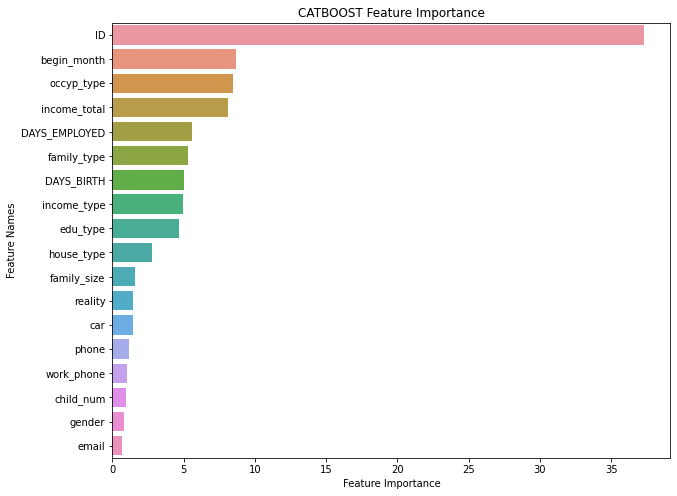

In [506]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    fig = plt.figure(figsize=(10,8))
    fig.set_facecolor("white")
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

plot_feature_importance(model_cat.get_feature_importance(),X_test.columns,'CATBOOST')

In [507]:
sub.iloc[:, :] = cat_pred_test
sub

,0,1,2
index,,,
26457,0.143012,0.166517,0.690471
26458,0.167600,0.137744,0.694657
26459,0.139023,0.161421,0.699557
26460,0.099370,0.146425,0.754205
26461,0.119269,0.231810,0.648921
...,...,...,...
36452,0.079155,0.168868,0.751977
36453,0.098039,0.168262,0.733699
36454,0.037407,0.097519,0.865073


In [508]:
import os
path = "/content/drive/MyDrive/머신러닝_실전예제/Dacon_신용카드연체판별/result/"
file_list = os.listdir(path)
file_list_csv = [file for file in file_list if file.endswith(".csv")]
num = len(file_list_csv) + 1

In [509]:
sub.to_csv("/content/drive/MyDrive/머신러닝_실전예제/Dacon_신용카드연체판별/result/result" + str(num) + ".csv")